Since I'm now learning photography, I've been doing a bit of reading on optics foundations. In this post, I'll try to perform a couple computations and ray tracing for a spherical lens.

# The spherical lens problem 

Let's suppose your camera has a spherical lens. Further supposing it's 2D, we can model it as a circle. We now imagine that a point is scattering light rays in all directions through this spherical lens. Our goal is then:

- to compute the point of intersection with the lens
- determine the angle of the incoming ray
- apply Snell's law in order to determine the refracted ray angle

Here, we're supposing that the incident medium is air ($n = 1$) and the lens medium is glass ($n = 1.5$).

# Modelling the important concepts

First, the lens (we assume that it's centered at the $(0, 0)$ point):

In [1]:
from collections import namedtuple

In [2]:
Lens = namedtuple('Lens', field_names=['r', 'n'])

In [3]:
lens = Lens(r=10, n=1.5)

lens

Lens(r=10, n=1.5)

Next, the point source. We will model locations as complex numbers.

In [4]:
PointSource = namedtuple('PointSource', field_names=['coord'])

In [5]:
source = PointSource(coord=(-10 + 0j))

And now, the ray:

In [6]:
Ray = namedtuple('Ray', field_names=['origin', 'direction'])

In [7]:
ray = Ray(origin=source, direction=(1+.1j))

Using a ray, we can derive its line equation easily:

In [8]:
ray.origin.coord

(-10+0j)

In [9]:
ray.direction.real

1.0

In [10]:
def line_equation(ray):
    """Returns line equation ax + by + c = 0."""
    a = - ray.direction.imag
    b = ray.direction.real
    c = ray.origin.coord.real * ray.direction.imag - ray.origin.coord.imag * ray.direction.real
    return a, b, c

We can use thise equation to write a plotting function for rays:

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ray(ray, xmin, xmax, ax=None):
    """Plots a ray."""
    a, b, c = line_equation(ray)
    if ax is None:
        ax = plt.gca()
    # assuming b is different from 0!
    assert b != 0
    start = (xmin, (-c - a * xmin) / b)
    end = (xmax, (-c - a * xmax) / b)
    
    xy = np.c_[np.array((start, end))]
    ax.plot(xy[:, 0], xy[:, 1], '-ko')

In [12]:
%matplotlib inline

Let's plot some parallel rays:

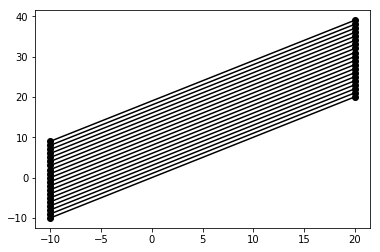

In [13]:
for origin_y in np.arange(-10, 10):
    ray = Ray(origin=PointSource(-10 + 1j * origin_y), direction=(1+1j))
    plot_ray(ray, -10, 20)

As well as some spherical rays:

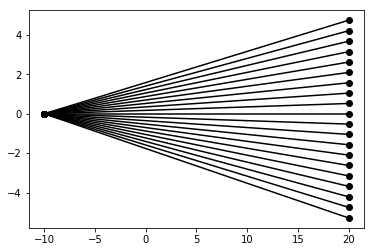

In [14]:
for theta_deg in np.arange(-10, 10):
    ray = Ray(origin=PointSource(-10 + 1j * 0), direction=(np.cos(np.deg2rad(theta_deg)) + 1j * np.sin(np.deg2rad(theta_deg))))
    plot_ray(ray, -10, 20)

# Intersections 

Using these elements, we can write model an intersection routine:

In [15]:
from math import sqrt

def intersection(ray, lens, verbose=False):
    """Returns intersection point of ray with lens."""
    a, b, c = line_equation(ray)
    r = lens.r
    if verbose: print(f"a: {a}, b: {b}, c: {c}, r: {r}")
    aa = 1 + a**2/b**2
    bb = 2 * a * c / b**2
    cc = c**2/b**2 - r**2
    delta = bb**2 - 4 * aa * cc
    if verbose: print(f"aa: {aa}, bb: {bb}, cc: {cc}, delta: {delta}")
    if delta >= 0:
        if delta == 0:
            root = -bb / (2 * aa)
            yplus = sqrt(r**2 - root**2)
            return root + 1j * yplus, root - 1j * yplus 
        else:
            roots = ((- bb + sqrt(delta)) / (2 * aa),
                    (- bb - sqrt(delta)) / (2 * aa))
            intersection_points = []
            for root in roots:
                for sign in [1, -1]:
                    x, y = root, sign * sqrt(r**2 - root**2)
                    if abs(a * x + b * y + c) <= 1e-5:
                        intersection_points.append(x + 1j * y)
            intersection_points = [intersection_point for intersection_point in intersection_points \
                                       if abs(intersection_point - ray.origin.coord) >= 1e-5]
            return min(intersection_points, key=lambda p: abs(p - ray.origin.coord))
    else:
        return None

Let's test this:

In [16]:
lens = Lens(r=1, n=1.5)
source = PointSource(coord=(-2 + 0j))
ray = Ray(origin=source, direction=(1-0.2j))

intersection(ray, lens, verbose=True)

a: 0.2, b: 1.0, c: 0.4, r: 1
aa: 1.04, bb: 0.16000000000000003, cc: -0.84, delta: 3.52


(-0.9789261076583519-0.20421477846832947j)

# The refracted ray 

We can now determine the angle of the incoming ray, relative to the local normal of the lens by using the Snell law. To do this, there are a number of subproblems to solve:

- compute the normal and the tangential vector from an intersection point on the circle
- compute the incoming angle and deduce the refracted angle
- compute the new ray vector

## Normals on the circle 

A simple approach to this problem is to use polar coordinates:

In [17]:
from math import atan2, cos, sin

def lens_normal_tangent(intersection_point, lens):
    """Returns the normal vector associated to the lens."""
    circle_theta = atan2(intersection_point.imag / lens.r, intersection_point.real / lens.r)
    normal = cos(circle_theta) + 1j * sin(circle_theta)
    tangent = -sin(circle_theta) + 1j * cos(circle_theta)
    return normal, tangent

Let's see if the results are correct:

[-2, 0, -1, 1]

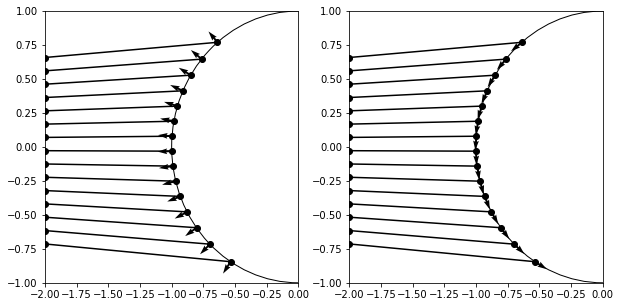

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))
ax[1].add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for theta_deg in np.arange(-5.1, 5, 0.7):
    ray = Ray(origin=PointSource(-10 + 1j * 0), direction=(np.cos(np.deg2rad(theta_deg)) + 1j * np.sin(np.deg2rad(theta_deg))))
    point = intersection(ray, lens)
    if point is not None:
        normal, tangent = lens_normal_tangent(point, lens)
        ax[0].quiver([point.real], [point.imag], [normal.real], [normal.imag])
        plot_ray(ray, source.coord.real, point.real, ax=ax[0])
        
        ax[1].quiver([point.real], [point.imag], [tangent.real], [tangent.imag])
        plot_ray(ray, source.coord.real, point.real, ax=ax[1])
        
ax[0].axis([-2, 0, -1, 1])
ax[1].axis([-2, 0, -1, 1])

## Refracted ray

Let's now compute the refracted ray.

In [19]:
def dot_product(v1, v2):
    """Returns the dot product between two vectors represented as complex numbers."""
    return (v1 * v2.conjugate()).real

In [20]:
from math import acos, asin, copysign

def compute_refracted_ray(ray, intersection_point, lens, inward=True):
    """Returns the ray refracted by the lens at the given intersection point."""
    normal, tangent = lens_normal_tangent(intersection_point, lens)
    # checking for inward/outward 
    if inward:
        n1 = 1.
        n2 = lens.n
    else:
        n1 = lens.n
        n2 = 1.
    incoming = ray.direction - intersection_point
    incoming /= abs(incoming)
    dotprod = dot_product(normal, incoming)
    if dotprod**2 <= 1:
        refracted_angle = asin(n1 / n2 * sqrt(1 - dotprod**2))
        refracted_angle = copysign(refracted_angle, -dot_product(tangent, incoming))
        refracted_dir = cos(refracted_angle) * normal + sin(refracted_angle) * tangent 
        return normal, Ray(PointSource(intersection_point), refracted_dir)
    else:
        return normal, None

Let's test the output of this function:

[-4, 4, -4, 4]

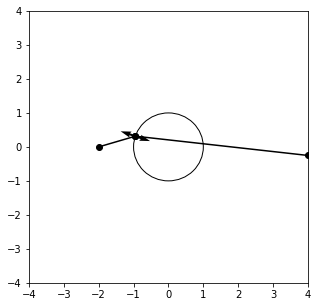

In [21]:
lens = Lens(r=1, n=1.5)
source = PointSource(coord=(-2 + 0j))
ray = Ray(origin=source, direction=(1+0.3j))
intersection(ray, lens)

fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))
point = intersection(ray, lens)
plt.plot(point.real, point.imag, 'o')
normal, refracted_ray = compute_refracted_ray(ray, point, lens)
plt.quiver([point.real], [point.imag], [-normal.real], [-normal.imag])
plt.quiver([point.real], [point.imag], [normal.real], [normal.imag])
plot_ray(ray, source.coord.real, point.real)
plot_ray(refracted_ray, point.real, 4)
ax.axis([-4, 4, -4, 4])

# Applying the tracing to several setups 

Now let's see if we can plot several rays:

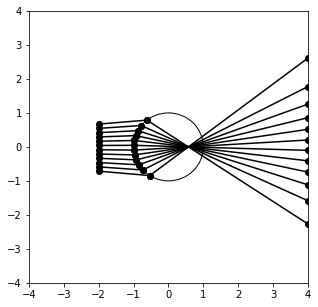

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for theta_deg in np.arange(-5.1, 5, 0.9):
    ray = Ray(origin=PointSource(-10 + 1j * 0), direction=(np.cos(np.deg2rad(theta_deg)) + 1j * np.sin(np.deg2rad(theta_deg))))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        plot_ray(ray, source.coord.real, point.real)
        plot_ray(refracted_ray, point.real, 4)
        ax.axis([-4, 4, -4, 4])

Does this change if all rays are horizontal and farther away?

[-4, 4, -4, 4]

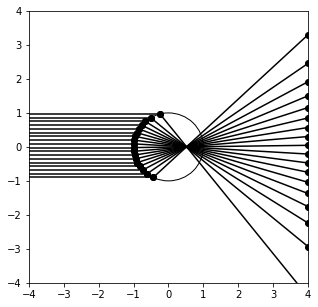

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for origin_y in np.arange(-2, 2, 0.11):
    ray = Ray(origin=PointSource(-10 + 1j * origin_y), direction=(1 + 0j))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        plot_ray(ray, ray.origin.coord.real, point.real)
        plot_ray(refracted_ray, point.real, 4)
ax.axis([-4, 4, -4, 4])

[-4, 4, -4, 4]

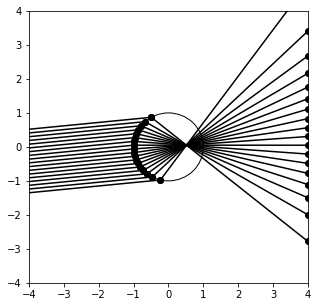

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for origin_y in np.arange(-2, 2, 0.11):
    ray = Ray(origin=PointSource(-5 + 1j * origin_y), direction=(1 + 0.1j))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        plot_ray(ray, ray.origin.coord.real, point.real)
        plot_ray(refracted_ray, point.real, 4)
ax.axis([-4, 4, -4, 4])

# Taking into account the full lens 

Of course, here we are not taking the second refraction into account correctly, since we're just tracing rays outwards from the lens. Let's try to add this element.

[-4, 4, -4, 4]

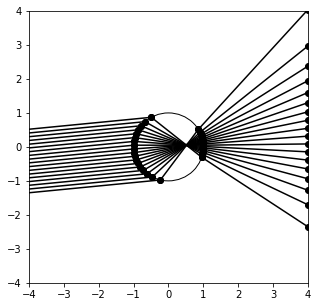

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for origin_y in np.arange(-2, 2, 0.11):
    ray = Ray(origin=PointSource(-5 + 1j * origin_y), direction=(1 + 0.1j))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        point2 = intersection(refracted_ray, lens)
        if point2 is not None:
            normal2, refracted_ray2 = compute_refracted_ray(refracted_ray, point2, lens, inward=False)
        
        # plotting
        if point is not None:
            plot_ray(ray, ray.origin.coord.real, point.real)
            if point2 is not None:
                plot_ray(refracted_ray, point.real, point2.real)
                if refracted_ray2 is not None:
                    plot_ray(refracted_ray2, point2.real, 4)
ax.axis([-4, 4, -4, 4])

What about some point like source?

[-4, 4, -4, 4]

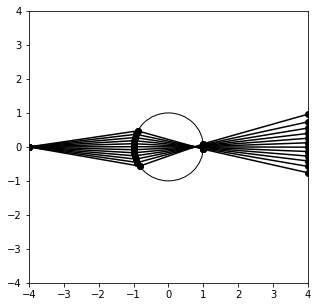

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for theta_deg in np.arange(-10.1, 10, 1.7):
    ray = Ray(origin=PointSource(-4 + 1j * 0), direction=(np.cos(np.deg2rad(theta_deg)) + 1j * np.sin(np.deg2rad(theta_deg))))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        point2 = intersection(refracted_ray, lens)
        if point2 is not None:
            normal2, refracted_ray2 = compute_refracted_ray(refracted_ray, point2, lens, inward=False)
        
        # plotting
        if point is not None:
            plot_ray(ray, ray.origin.coord.real, point.real)
            if point2 is not None:
                plot_ray(refracted_ray, point.real, point2.real)
                if refracted_ray2 is not None:
                    plot_ray(refracted_ray2, point2.real, 4)
ax.axis([-4, 4, -4, 4])

[-4, 4, -4, 4]

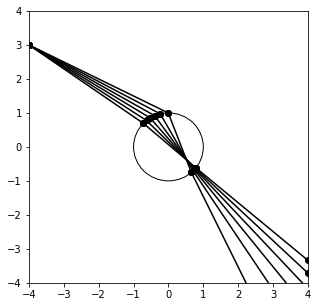

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), radius=lens.r, fill=None))

for theta_deg in np.arange(-35.1, -10, 1.7):
    ray = Ray(origin=PointSource(-4 + 1j * 3), direction=(np.cos(np.deg2rad(theta_deg)) + 1j * np.sin(np.deg2rad(theta_deg))))
    point = intersection(ray, lens)
    if point is not None:
        normal, refracted_ray = compute_refracted_ray(ray, point, lens)
        point2 = intersection(refracted_ray, lens)
        if point2 is not None:
            normal2, refracted_ray2 = compute_refracted_ray(refracted_ray, point2, lens, inward=False)
        
        # plotting
        if point is not None:
            plot_ray(ray, ray.origin.coord.real, point.real)
            if point2 is not None:
                plot_ray(refracted_ray, point.real, point2.real)
                if refracted_ray2 is not None:
                    plot_ray(refracted_ray2, point2.real, 4)
ax.axis([-4, 4, -4, 4])

**Note** there was a bug in my code initially, but thanks to my friend ZRC's review, this is now corrected. Thank you!

# Conclusions 

Let's stop this exploration here. As we have seen in this blog entry, it's not that difficult to trace a couple of rays going through an imaging system. Using the above plots, we've seen that a spherical lens always focuses the rays into its center, even if they come from different directions and angles. This is one of the wonderful properties of imaging systems. I quote [this](http://web.mit.edu/2.710/Fall06/2.710-wk2-b-sl.pdf) MIT lecture on optics  to better explain why I think this is interesting:

- Each point in an object scatters the incident illumination into a spherical wave, according to the Huygens principle.
- A few microns away from the object surface, the rays emanating from all object points become entangled, delocalizing object details.
- To relocalize object details, a method must be found to reassign (“focus”) all the rays that emanated from a single point object into another point in space (the “image.”)

Now back to enjoying my camera that does all this hard work automatically for me!

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20180423_RayLensIntersection.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20180423_RayLensIntersection.ipynb).*